**PARTE 3 (EXTRA) - CLUSTERIZACIÓN**

In [16]:
import numpy as np
user_embeddings_weights = np.load("user_embeddings_weights.npy")

In [17]:
# Visualización 3D de las tres primeras dimensiones de los embeddings
import plotly.io as pio
pio.renderers.default = 'browser'

import plotly.graph_objects as go
import webbrowser

fig = go.Figure()

# Agregar los embeddings como puntos en el espacio 3D
fig.add_trace(go.Scatter3d(
    x=user_embeddings_weights[:, 0],
    y=user_embeddings_weights[:, 1],
    z=user_embeddings_weights[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=user_embeddings_weights[:, 2],
        colorscale='Viridis',
        opacity=0.8
    )
))

# Ajustar el layout del gráfico
fig.update_layout(
    scene=dict(
        xaxis_title="Dimensión 1",
        yaxis_title="Dimensión 2",
        zaxis_title="Dimensión 3"
    ),
    title="Visualización de Embeddings en 3D",
    width=800,
    height=600
)

# Mostrar el gráfico
fig.write_html('temp.html', auto_open=True)

# Abrir el HTML
webbrowser.open_new_tab('temp.html')

True

•	Agrupar los usuarios utilizando el algoritmo de Kmeans. Describir cada cluster encontrado.

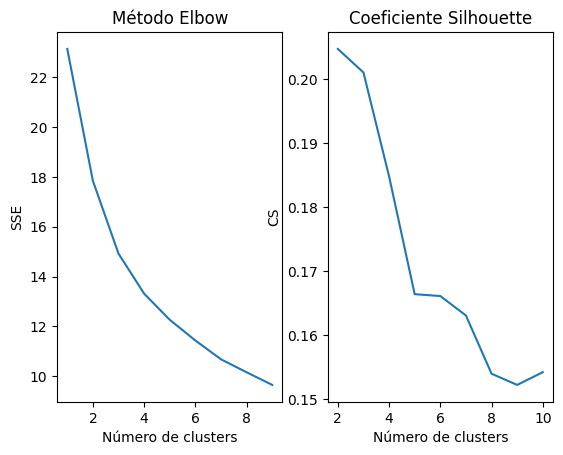

In [18]:
# Clusterización con KMEANS
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Calcular cantidad de clusters óptimos
# Método Elbow
ssd = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(user_embeddings_weights)
    ssd[k] = kmeans.inertia_ # Inertia: Sum of squared distances of samples to their closest cluster center

plt.subplot(1, 2, 1)
plt.title('Método Elbow')
plt.plot(list(ssd.keys()), list(ssd.values()))
plt.xlabel("Número de clusters")
plt.ylabel("SSE")

# Coeficiente Silhouette
cs = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(user_embeddings_weights)
    cs[k] = silhouette_score(user_embeddings_weights, kmeans.labels_, metric='euclidean') 

plt.subplot(1, 2, 2)
plt.title('Coeficiente Silhouette')
plt.plot(list(cs.keys()), list(cs.values()))
plt.xlabel("Número de clusters")
plt.ylabel("CS")

plt.show()

<Axes: xlabel='tsne_1', ylabel='tsne_2'>

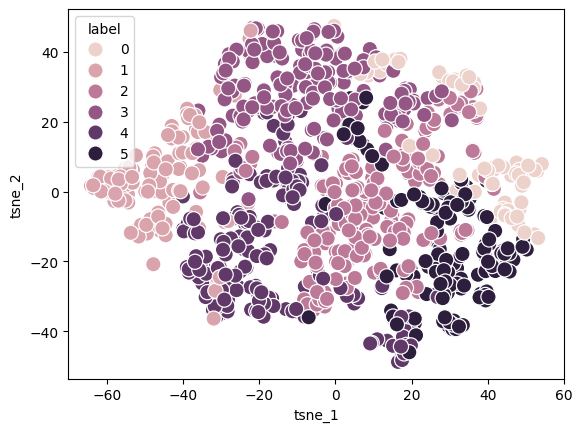

In [20]:
# Generar clusters con Kmeans y graficar
from sklearn.manifold import TSNE
import pandas as pd 
import seaborn as sns

kmeans = KMeans(n_clusters=6, max_iter=1000, n_init=10).fit(user_embeddings_weights)

tsne = TSNE(n_components=2, perplexity=15, random_state = 10)
tsne_result = tsne.fit_transform(user_embeddings_weights)

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0],'tsne_2': tsne_result[:,1], "label":kmeans.labels_})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue= "label", data=tsne_result_df, ax=ax,s=120)

In [21]:
# Clusterización con DBSCAN
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.04, min_samples=3).fit(user_embeddings_weights)
np.unique(dbscan.labels_) #Noisy samples are given the label -1.

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16])

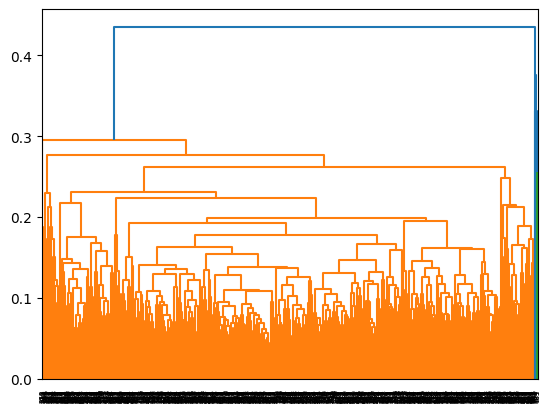

In [22]:
# Clusterización con método jerárquico
from scipy.cluster.hierarchy import dendrogram, linkage
jerarquico = linkage(user_embeddings_weights, method='average', metric='euclidean')
dendrogram(jerarquico)
plt.show()

In [23]:
#Kohonen
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
import matplotlib.pyplot as plt

# Paso 1: Normalizar de los embeddings
scaler = MinMaxScaler()
user_embeddings_scaled = scaler.fit_transform(user_embeddings_weights)

# Paso 2: Definir y entrenar la red SOM
# Asumiendo que los embeddings son de dimensión 32
input_len = user_embeddings_scaled.shape[1]

# Definir la SOM con un tamaño de 10x10
som = MiniSom(x=10, y=10, input_len=input_len, sigma=1.0, learning_rate=0.5)

# Inicializar los pesos de manera aleatoria
som.random_weights_init(user_embeddings_scaled)

# Entrenar la red con los embeddings de los usuarios
som.train_random(user_embeddings_scaled, 100)  # Ajustar número de iteraciones según sea necesario

# Paso 3: Visualización de los clusters
plt.figure(figsize=(10, 10))

for i, user_embedding in enumerate(user_embeddings_scaled):
    w = som.winner(user_embedding)  # Nodo ganador
    plt.text(w[0] , w[1] , str(i),  # Usamos el índice del usuario
             color=plt.cm.rainbow(i / len(user_embeddings_scaled)),  # Colorear cada punto
             fontdict={'weight': 'bold', 'size': 68})  # Aumentar tamaño de letra

# Añadir líneas de cuadrícula
plt.grid(True)
plt.title('Clusters de usuarios utilizando SOM', fontsize=22)  # Aumentar tamaño del título
plt.xlim([0, som.x])
plt.ylim([0, som.y])
plt.gca().invert_yaxis()  # Invertir el eje Y para visualizar correctamente
plt.show()

#¿Cómo interpretar el gráfico de la SOM?
#Nodos en la cuadrícula: Cada celda o punto en la cuadrícula SOM es un nodo ganador. Estos nodos representan "grupos" o "clusters" de datos. En cada iteración del entrenamiento, los datos (en este caso, embeddings de usuarios) se asignan al nodo ganador más cercano.
#
#Ubicación de los usuarios: Los puntos o textos que ves en el gráfico indican la posición del nodo ganador para cada usuario. Usuarios cuyos embeddings son más similares estarán asignados a nodos ganadores cercanos en la cuadrícula. De esta manera, la proximidad en el gráfico sugiere similitud.
#
#Colores: Se asigna un color diferente a cada usuario para que sea más fácil distinguirlos en el gráfico. Sin embargo, el color en sí no tiene un significado numérico; es solo una ayuda visual.
#
#Clusters: Cuando varios usuarios se asignan a un mismo nodo (o nodos cercanos), eso indica que sus embeddings son muy parecidos, lo cual significa que están agrupados en el mismo cluster. Cuantos más usuarios estén agrupados en un mismo nodo o alrededor de nodos cercanos, mayor es la similitud entre esos usuarios.

#Espacios vacíos: Si ves áreas en la cuadrícula donde no hay usuarios asignados, eso significa que no hay embeddings que sean lo suficientemente cercanos a esos nodos ganadores. Esas áreas pueden representar regiones del espacio donde no existe ningún usuario.

#En lugar de obtener un número específico de clusters como con k-means, aquí obtienes una cuadrícula donde cada celda es un posible cluster. Los usuarios que caen en celdas cercanas o en la misma celda son parte del mismo grupo. No se genera un número explícito de clusters, pero los patrones de agrupamiento en la cuadrícula son lo que debes observar:

#Si ves varios usuarios en la misma celda, eso indica que esos usuarios están en el mismo grupo o cluster.
#Usuarios en celdas adyacentes también pueden ser considerados como parte de un cluster más amplio, dependiendo de cuán similares sean sus embeddings.


AttributeError: 'MiniSom' object has no attribute 'x'

In [24]:
clusters = {}  # Diccionario para guardar los clusters

for i, user_embedding in enumerate(user_embeddings_scaled):
    w = som.winner(user_embedding)  # Nodo ganador
    if w not in clusters:
        clusters[w] = []  # Crear una nueva entrada en el cluster si no existe
    clusters[w].append(i)  # Asignar el usuario al cluster

# Mostrar los clusters
for cluster, users in clusters.items():
    print(f"Cluster {cluster}: Usuarios {users}")


Cluster (5, 7): Usuarios [0, 376, 411, 553, 564, 744, 806, 924]
Cluster (8, 3): Usuarios [1, 6, 73, 151, 266, 397, 609, 829, 857, 937]
Cluster (5, 5): Usuarios [2, 145, 174, 271, 345, 398, 715, 716, 741, 910]
Cluster (3, 2): Usuarios [3, 102, 229, 401, 490, 521, 656, 832, 866]
Cluster (9, 0): Usuarios [4, 96, 233, 372, 534]
Cluster (9, 3): Usuarios [5, 40, 107, 325, 327, 446, 575, 685, 713, 774, 790]
Cluster (2, 8): Usuarios [7, 117, 278, 298, 332, 369, 450, 841, 877]
Cluster (4, 9): Usuarios [8, 16, 210, 251, 276, 317, 353, 402, 415, 474, 622, 673, 691, 694, 895]
Cluster (4, 7): Usuarios [9, 25, 67, 99, 137, 341, 386, 588, 802, 848, 859]
Cluster (7, 5): Usuarios [10, 54, 60, 367, 598, 840, 888]
Cluster (4, 8): Usuarios [11, 236, 417, 552, 792, 879]
Cluster (8, 7): Usuarios [12, 52, 320, 428, 514, 606, 697, 767, 834, 838, 891, 942]
Cluster (2, 9): Usuarios [13, 22, 392, 419, 503, 556, 863]
Cluster (5, 2): Usuarios [14, 75, 136, 160, 322, 339, 501, 583, 643, 758, 765, 903, 936]
Cluster 

CONCLUSION: Luego de probar varias de técnicas de clusterización (kmeans -previamente analizando cantidad de clusters por método Elbow y el coeficente Silhouette-, DBSCAN, método jerárquico y Kohonen), se observa que no hay claros agrupamientos entre los usuarios. Cabría reentrenar el modelo con más datos y/o agregar variables que permitan una mejor estimación de los embeddings (características que distingan mejor a los usuarios) y así una mayor distinción y agrupación por similitud entre ellos.